# Code to plot and observe the raw data

Import libraries

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit
import plotly.express as px

Define functions

In [248]:
def get_indices_in_range(lst, start, end):
    """
    Returns a new list containing only the indices of the values within the given range (inclusive).
    """
    return [i for i, x in enumerate(lst) if start <= x <= end]

def remove_indexes(my_list, indexes_to_remove):
    return [x for i, x in enumerate(my_list) if i not in indexes_to_remove]

def read_dat_file(filename,skip):
    data = np.loadtxt(filename+'.dat',skiprows= skip,encoding='unicode_escape') #utf-8-sig')
    col = []
    num = len(data.transpose())
    for i in range(num):
        if num == len(data):
            col1 = data[i]
        else:
            col1 = data[:,i]
        col.append(col1)

    return col

def gaussian(x, a, x0, sigma):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-(x - x0)**2/ (2 * sigma**2))


def gaussian_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amp, cen, wid = params[i:i+3]
        y = y + amp * np.exp(-(x-cen)**2 / (2*wid**2))
    return y


def asymmetric_gaussian(x, I0, x0, w1, w2):
    #global yl 
    #global yr
    return 1/2*I0*(1-np.sign(x-x0))*np.exp(-(x - x0)**2/ (2 * w1**2)) + 1/2*I0*(1-np.sign(x0-x))*np.exp(-(x - x0)**2/ (2 * w2**2))# +1/2*yl*(1-np.sign(x-x0)) + 1/2*yr*(1-np.sign(x0-x))


def asymmetric_gaussian_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 4):
        I0, x0, w1, w2 = params[i:i+4]
        y = y + 1/2*I0*(1-np.sign(x-x0))*np.exp(-(x - x0)**2/ (2 * w1**2)) + 1/2*I0*(1-np.sign(x0-x))*np.exp(-(x - x0)**2/ (2 * w2**2)) #+1/2*yl*(1-np.sign(x-x0)) + 1/2*yr*(1-np.sign(x0-x))
    return y

def my_round(x,dx):      # per avere dato + errore con le giuste cire significative (incertezza con una sola cifra significativa)  ---> da sistemare,quando dx salta di cifra x resta arrotondato a cifra sotto
    round_x = []
    if np.size(x) > 1:
        for i in range(np.size(x)):
            if dx[i] < 1:
                dist = -int(np.log10(dx[i])-1)
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx[i]))
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)))
            round_x.append([x_new,dx_new])
    else:
            if dx < 1:
                dist = -int(np.log10(dx)-1)
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx))
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)))
            round_x.append([x_new, dx_new])
    return round_x

# Detector parameters

channels = read_dat_file('efficiency',3)[0] # canali del detector
angle_range = 128   # range angolare del detector
lamda = 0.729 # Angstrom inversi


def steps_to_angle(steps):
    angle = steps*angle_range/np.size(channels)    # max angle / n of channels
    return angle

def steps_to_q(steps):
    angle = steps*angle_range/np.size(channels) 
    q = 4*np.pi*np.sin(angle*np.pi/360)/lamda   # in Angstrom inversi
    return q

#Define scattering angle 2theta and exchanged wavewector q
angle = steps_to_angle(channels)
q = steps_to_q(channels)

In [249]:
# function to plot data

def plot_raw_data(file0,num_files, title):
    efficiency = read_dat_file('efficiency',3)[1]
    filename = []

    for i in range (num_files):
        num = int(file0) + i
        num = str(num)
        filename.append('bs'+num)

    data = []
    err_data = []

    for i in range (num_files):
        name = filename[i]
        data.append(read_dat_file(name,3)[1]/efficiency)
        err_data.append(read_dat_file(name,3)[2]/efficiency)
        plt.errorbar(channels,data[i], fmt = '-', yerr = err_data[i] ,label = name)
    plt.xlabel('Channel')
    plt.ylabel('Intensity  [counts]')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()
    return data, err_data


# Efficiency

efficiency    

Efficiency of channels: divide by it to smooth data

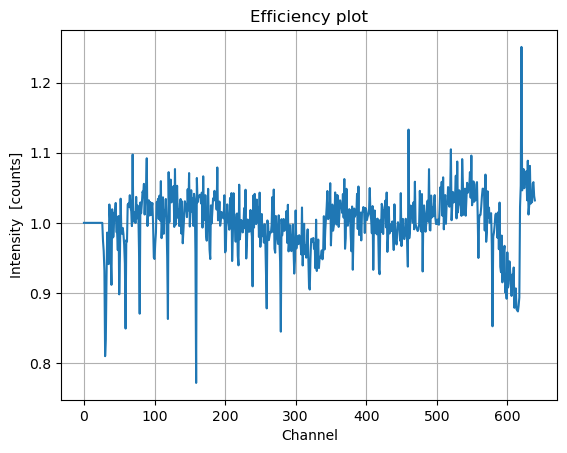

In [250]:
efficiency = read_dat_file('efficiency',3)[1]
err_efficiency = read_dat_file('efficiency',3)[2]
plt.plot(channels,efficiency, '-')
plt.xlabel('Channel')
plt.ylabel('Intensity  [counts]')
plt.title('Efficiency plot')
plt.grid()
plt.show()

# NICKEL POWDER : Calibration $2 \theta$ vs. channel

Use Ni reflections to calibrate the scattering angle in function of the channel. One retrieves the peaks position in the Ni powder diffraction pattern and fits them to the Bragg law  
$$
\lambda = 2 d_{hkl}\sin(\theta)
$$

with $\lambda$ the neutron waveelngth selected at the monocromator, $d_{hkl}$ the d-spacing of planes (hkl) and $\theta$ is half the scattering angle, or the Bragg angle. This angle is associated to the correspondent channel in the detector by the linear relation

$$
\theta = \theta_0 + \Delta \theta channel
$$

and the angular step $\delta \theta$ is known to be $0.2^{\circ}$, since there are 640 channels covering an angular range of $128^{\circ}$.  
Then one finds the allowed reflections for the Ni powder (hkl), associate them with the observed peaks in the pattern and retrieves the corresponding d-spacing $d_{hkl}$ as 
$$
\frac{1}{d_{hkl}} = \frac{\sqrt{h^2+k^2+l^2}}{a}
$$

with $a = 3.524 \AA$ the lattice parameter at 293 K (from "High-temperature thermal expansion of six metallic elements measured by dilatation method and X-ray diffraction Sample: at T = 1433 K").  

Then the retrieved peaks position are fitted to the inverse of the Bragg law
$$
channel = \left(\arcsin\left(\frac{\lambda}{2 d_{hkl}}\right)-\theta_0\right)/\Delta \theta
$$
with $\Delta \theta = 0.2 \times\frac{\pi}{360}$ rad.  

To gain resolution and fit better the peaks 4 repetitions were done and in eaach one the detector was rotated 1/4 of step, in order to increase the number of data.  

bs44380	M=200000   
bs44381	M=200000 con detector ruotato di 0.05°  
bs44382	M=200000 con detector ruotato di 0.10°  
bs44383	M=200000 con detector ruotato di 0.14° 

Moreover, background subtraction is required to fit well the peaks position (up to now linear fit, better considering TDS), maybe also need to consider diffraction form cell containing the powder and/or data treatment of Petrillo and Sacchetti.


Import data of four repetitions

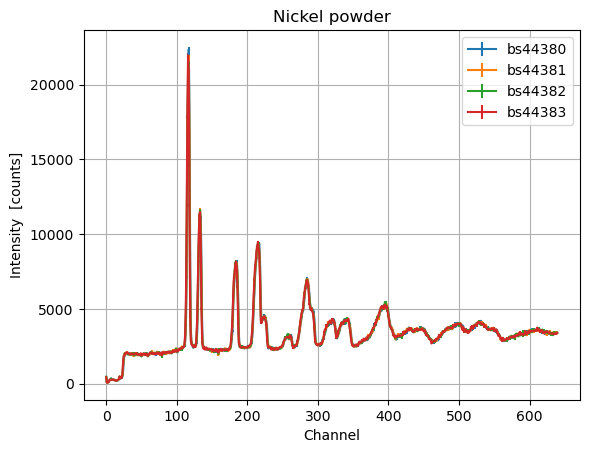

In [251]:
nickelone, err_nickelone = plot_raw_data('44380',4, 'Nickel powder')



Merge the four set of data by considering fractions of channel

In [252]:
step = np.zeros(4*np.size(channels))
nickel_back= np.zeros(4*np.size(channels))
err_nickel_back = np.zeros(4*np.size(channels))


for i in range(np.size(channels)):
    step[4*i] = i 
    step[4*i+1] = i + 0.25
    step[4*i+2] = i + 0.5
    step[4*i+3] = i + 0.14/0.2

    nickel_back[4*i] = nickelone[0][i]
    nickel_back[4*i+1] = nickelone[1][i]
    nickel_back[4*i+2] = nickelone[2][i]
    nickel_back[4*i+3] = nickelone[3][i]

    err_nickel_back[4*i] = err_nickelone[0][i]
    err_nickel_back[4*i+1] = err_nickelone[1][i]
    err_nickel_back[4*i+2] = err_nickelone[2][i]
    err_nickel_back[4*i+3] = err_nickelone[3][i]

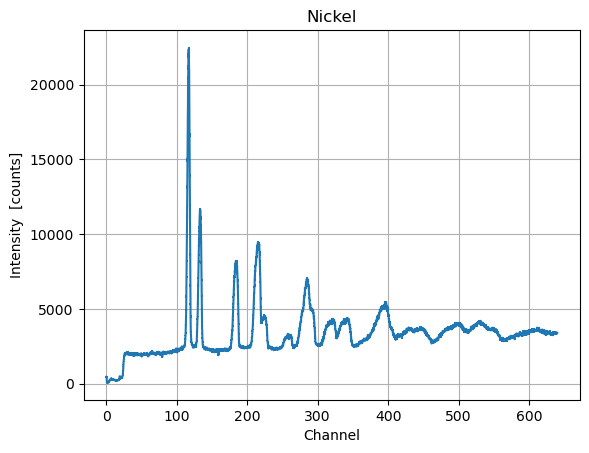

In [253]:
#%matplotlib ipympl
plt.errorbar(step,nickel_back, fmt = '-', yerr = err_nickel_back)
plt.xlabel('Channel')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel')
plt.grid()
plt.show()

Background subtraction: linear fit to data outside peaks, probably better to fit the whole profile considering the presence of constant background + TDS (see Suppplementary info to Real time Observation...). Problem: for TDS need already to know calibration.

Fit parameters
Intercept 1897.0 +/- 5.0 counts
Slope 2.06 +/- 0.03 counts/step


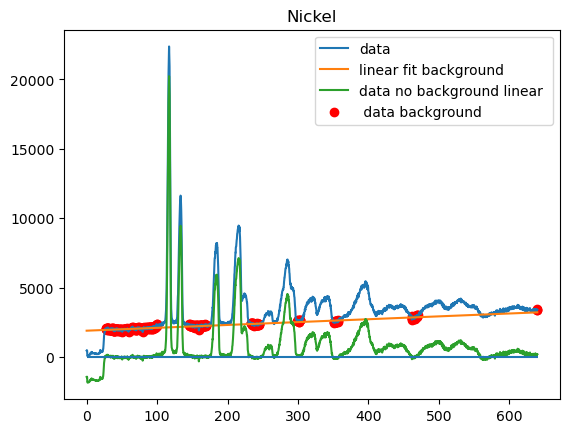

In [254]:
#background subtraction

#%matplotlib ipympl

def lin_fit(x,a,b):
    return a*x + b



indici = get_indices_in_range(step,0,27)
x_data_fondo = remove_indexes(list(step),indici)
y_data_fondo = remove_indexes(list(nickel_back),indici)

indici = get_indices_in_range(x_data_fondo,100,145)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,170,233)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,245,299)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,303,351)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,357,461)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,470,639)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

'''plt.plot(step,nickel[0],label="data")    
plt.scatter(x_data_fondo,y_data_fondo,label="background",color="red")   
plt.title("Nickel background")
plt.legend()
plt.show() '''
popt,pcov = curve_fit(lin_fit,x_data_fondo,y_data_fondo,sigma = np.sqrt(y_data_fondo))
par = my_round(popt,np.sqrt(np.diag(pcov)))
print('Fit parameters')
print('Intercept',par[1][0], '+/-', par[1][1],'counts')
print('Slope',par[0][0], '+/-', par[0][1],'counts/step')

plt.plot(step,nickel_back,label="data")
plt.plot(step,lin_fit(step,*popt),label="linear fit background")
plt.plot(step,nickel_back-lin_fit(step,*popt),label="data no background linear ")
plt.scatter(x_data_fondo,y_data_fondo,label=" data background",color="red")  
plt.hlines(0,0,640)
plt.title("Nickel")
plt.legend()
plt.show()

nickel = nickel_back - lin_fit(step, *popt)
err_nickel = np.sqrt(err_nickel_back**2 + pcov[0][0] + pcov[1][1])

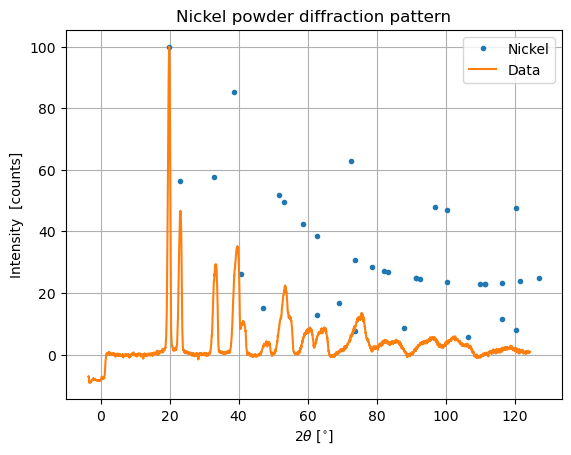

In [255]:
#Compare with diffraction pattern from VESTA
#%matplotlib ipympl
twotheta = read_dat_file('nickel_vesta',1)[7]
intensity = read_dat_file('nickel_vesta',1)[8]

twotheta_v = read_dat_file('vanadium_vesta',1)[7]
intensity_v = read_dat_file('vanadium_vesta',1)[8]

twotheta_al = read_dat_file('aluminum_vesta',1)[7]
intensity_al = read_dat_file('aluminum_vesta',1)[8]

plt.plot(twotheta,intensity,'.',label = 'Nickel')
#plt.plot(twotheta_v,intensity_v,'v',label = 'Vanadium')
#plt.plot(twotheta_al,intensity_al,'x',label = 'Aluminum')
plt.plot(steps_to_angle(step)-3.5,nickel*100/max(nickel),label = 'Data')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel powder diffraction pattern')
plt.legend()
plt.grid()
plt.show()

Function to fit a certain peak with a custom number of gaussians, need to give p0 as input return fit parameters and their errors.

In [256]:
def fit_peak(x,data, err_data, p0):

    bounds = []
    bounds.append(np.zeros(np.size(p0)))
    bounds.append(np.ones(np.size(p0))*np.inf)

    popt, pcov = curve_fit(gaussian_sum,x, data,sigma=err_data,p0=p0, bounds = bounds, maxfev = 80000)
    chi_sq = sum((gaussian_sum(x,*popt)-data)**2/err_data**2)/(len(data)-len(p0))
    par = my_round(popt,np.sqrt(np.diag(pcov)))

    for i in range(np.size(p0)//3):
        print('### Gaussian %d ####' % i)
        print('Peak position',par[3*i+1][0], '+/-', par[3*i+1][1],'channel')
        print('Peak height',par[3*i][0], '+/-', par[3*i][1],'counts')
        print('Peak width',par[3*i+2][0], '+/-', par[3*i+2][1],'channel')
    print('Chi squared / dof', chi_sq)
    x_plot = np.linspace(min(x), max(x),10000)
    plt.plot(x_plot, gaussian_sum(x_plot, *popt),color='red',label = 'Fit to %8.0f gaussians' %(len(p0)//3))

    for i in range(len(p0)//3):
        plt.plot(x_plot,gaussian(x_plot, *popt[3*i:3*i+3]),label = 'Gaussian %d' % (i+1))

    plt.errorbar(x,data, yerr=err_data, fmt = '.',label='Data')
    plt.xlabel('Channel')
    plt.ylabel('Intensity [counts]')
    plt.legend()
    plt.grid()
    plt.show()

    return popt, np.sqrt(np.diag(pcov))


Fit to asymmetric gaussian: two different widths before and after the peak

In [257]:
def fit_peak_asymmetric(x,data, err_data, p0):

    bounds = []
    bounds.append(np.zeros(np.size(p0)))
    bounds.append(np.ones(np.size(p0))*np.inf)

    popt, pcov = curve_fit(asymmetric_gaussian_sum,x, data,sigma=err_data,p0=p0, bounds = bounds, maxfev = 80000)

    chi_sq = sum((asymmetric_gaussian_sum(x,*popt)-data)**2/err_data**2)/(len(data)-len(p0))
    par = my_round(popt,np.sqrt(np.diag(pcov)))

    for i in range(np.size(p0)//4):
        print('### Gaussian %d ####' % i)
        print('Peak position',par[4*i+1][0], '+/-', par[4*i+1][1],'channel')
        print('Peak height',par[4*i][0], '+/-', par[4*i][1],'counts')
        print('Peak width left',par[4*i+2][0], '+/-', par[4*i+2][1],'channel')
        print('Peak width right',par[4*i+3][0], '+/-', par[4*i+3][1],'channel')
    print('Chi squared / dof', chi_sq)
    
    x_plot = np.linspace(min(x), max(x),10000)
    plt.plot(x_plot, asymmetric_gaussian_sum(x_plot, *popt),color='red',label = 'Fit to %8.0f gaussians' %(len(p0)//4))

    if len(p0) > 4:
        for i in range(len(p0)//4):
            plt.plot(x_plot,asymmetric_gaussian(x_plot, *popt[4*i:4*i+4]),label = 'Gaussian %d' % (i+1))

    plt.errorbar(x,data, yerr=err_data, fmt = '.',label='Data')
    plt.xlabel('Channel')
    plt.ylabel('Intensity [counts]')
    plt.legend()
    plt.grid()
    plt.show()

    return popt, np.sqrt(np.diag(pcov))


Picco 0

### Gaussian 0 ####
Peak position 117.14 +/- 0.03 channel
Peak height 20500.0 +/- 200.0 counts
Peak width left 1.89 +/- 0.03 channel
Peak width right 1.25 +/- 0.02 channel
Chi squared / dof 13.945374550565328


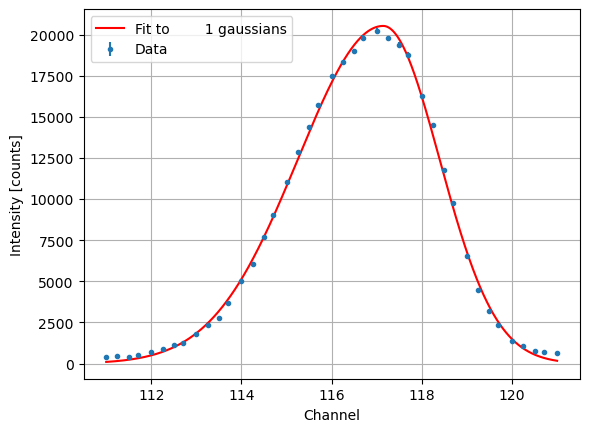

In [258]:
index = get_indices_in_range(step, 111, 121)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]
x_plot = np.linspace(min(x), max(x),10000)

p0 = [20000,117,1.8,1.4]


par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = par
err_nickel_parameters = err_par

Picco 1

### Gaussian 0 ####
Peak position 133.5 +/- 0.05 channel
Peak height 9800.0 +/- 100.0 counts
Peak width left 2.32 +/- 0.04 channel
Peak width right 1.4 +/- 0.04 channel
Chi squared / dof 9.56290289817082


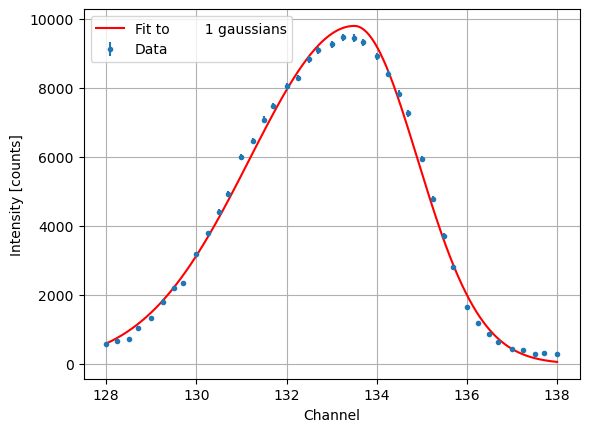

In [259]:
index = get_indices_in_range(step, 128, 138)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [9000, 133.5, 2,1]




par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)


Peak 2

### Gaussian 0 ####
Peak position 184.93 +/- 0.1 channel
Peak height 6300.0 +/- 100.0 counts
Peak width left 3.62 +/- 0.1 channel
Peak width right 1.74 +/- 0.1 channel
Chi squared / dof 22.687488800645102


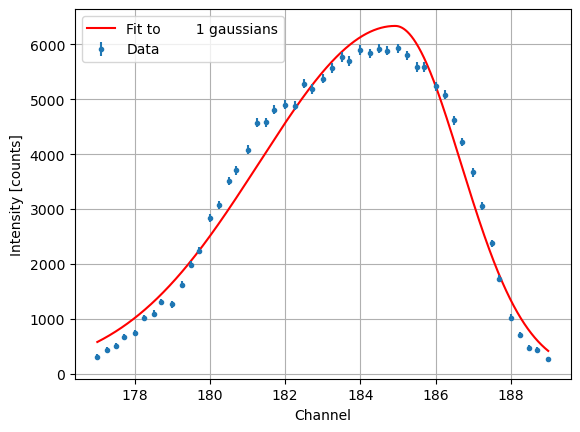

In [260]:
index = get_indices_in_range(step, 177, 189)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [5000, 184, 4,2]



par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 3 and 4

### Gaussian 0 ####
Peak position 215.86 +/- 0.1 channel
Peak height 7500.0 +/- 100.0 counts
Peak width left 4.6 +/- 0.1 channel
Peak width right 2.3 +/- 0.2 channel
### Gaussian 1 ####
Peak position 225.4 +/- 0.4 channel
Peak height 2280.0 +/- 90.0 counts
Peak width left 3.7 +/- 0.8 channel
Peak width right 2.1 +/- 0.3 channel
Chi squared / dof 20.8078583270788


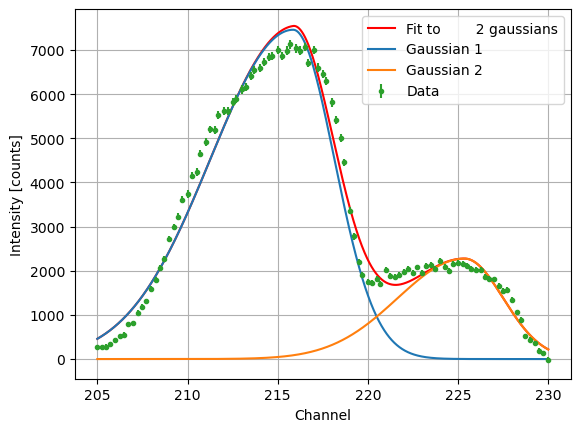

In [261]:
index = get_indices_in_range(step, 205, 230)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [7000,215,5,3,2000,225,5,3]

par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 5  
Fit to simple gaussian

### Gaussian 0 ####
Peak position 258.2 +/- 0.2 channel
Peak height 780.0 +/- 30.0 counts
Peak width 4.8 +/- 0.2 channel
Chi squared / dof 4.908097473977213


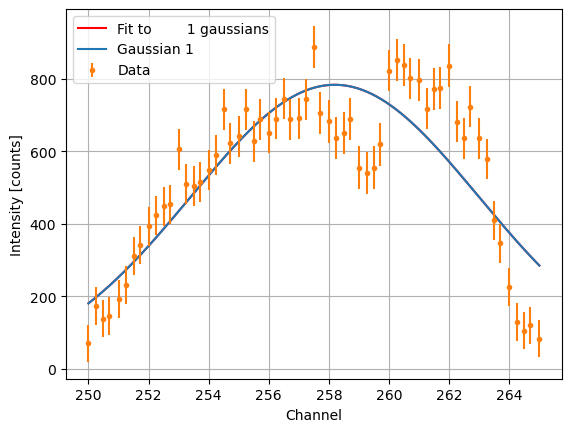

In [262]:
index = get_indices_in_range(step, 250, 265)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [810,259,2]

par, err_par = fit_peak(x,data,err_data,p0)

par = np.append(par,par[2])
err_par = np.append(err_par,err_par[2])

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 6 and 7

### Gaussian 0 ####
Peak position 285.0 +/- 0.2 channel
Peak height 3900.0 +/- 200.0 counts
Peak width left 6.53 +/- 0.09 channel
Peak width right 2.73 +/- 0.1 channel
### Gaussian 1 ####
Peak position 293.43 +/- 0.1 channel
Peak height 2360.0 +/- 50.0 counts
Peak width left 4.9 +/- 0.7 channel
Peak width right 1.85 +/- 0.1 channel
Chi squared / dof 3.1816192920914705


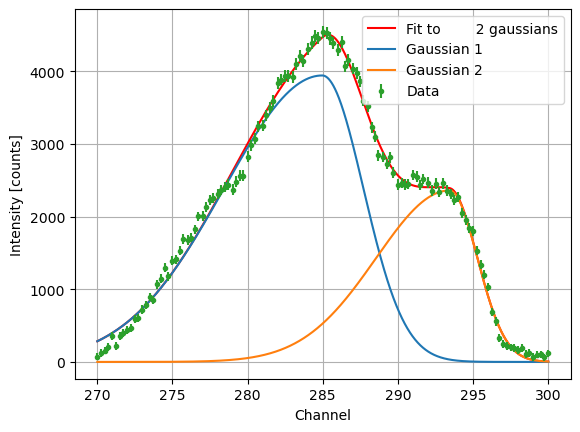

In [263]:
index = get_indices_in_range(step, 270, 300)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [4500,285,10,5,2500,292,5,3]

par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 8 and 9

### Gaussian 0 ####
Peak position 321.4 +/- 0.3 channel
Peak height 1590.0 +/- 40.0 counts
Peak width left 9.2 +/- 0.3 channel
Peak width right 2.5 +/- 0.2 channel
### Gaussian 1 ####
Peak position 343.2 +/- 0.2 channel
Peak height 1770.0 +/- 30.0 counts
Peak width left 11.2 +/- 0.4 channel
Peak width right 2.6 +/- 0.2 channel
Chi squared / dof 5.625506010195991


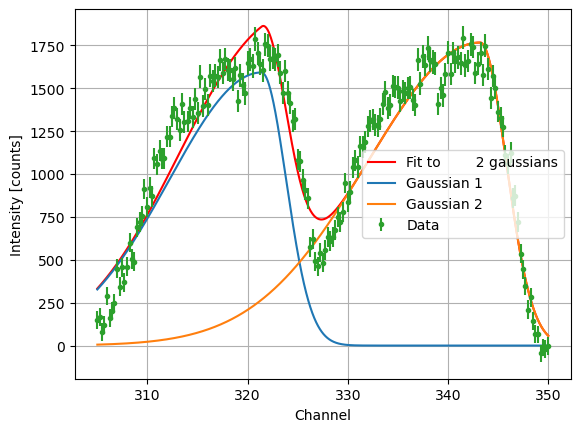

In [264]:
index = get_indices_in_range(step, 305, 350)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [1750,317,10,5,1750,340,10,5]

par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 8  
From here there are amny allowe reflections for peak, then one could possibly fi tthe peaks with more gaussians --> overfitting is a serious risk

In [265]:
'''index = get_indices_in_range(step, 370, 410)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [900,380, 10,900,400,10]

par, err_par = fit_peak(x,data,err_data,p0)

#nickel_parameters = np.append(nickel_parameters,par)
#err_nickel_parameters= np.append(err_nickel_parameters,err_par)'''

'index = get_indices_in_range(step, 370, 410)\nx = step[index]\ndata = nickel[index]\nerr_data = err_nickel[index]\n\np0 = [900,380, 10,900,400,10]\n\npar, err_par = fit_peak(x,data,err_data,p0)\n\n#nickel_parameters = np.append(nickel_parameters,par)\n#err_nickel_parameters= np.append(err_nickel_parameters,err_par)'

### Gaussian 0 ####
Peak position 395.2 +/- 0.2 channel
Peak height 2480.0 +/- 20.0 counts
Peak width left 12.1 +/- 0.2 channel
Peak width right 7.0 +/- 0.2 channel
Chi squared / dof 2.7516462791049823


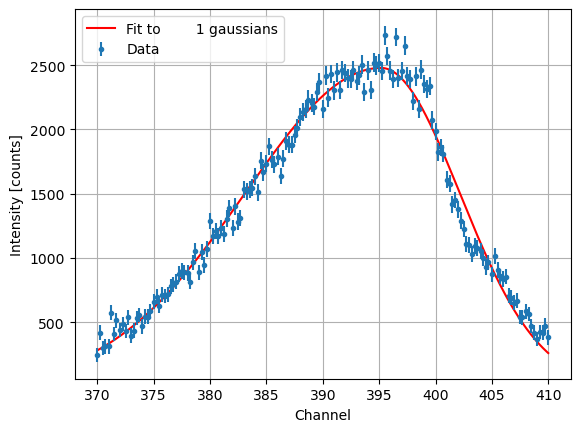

In [266]:
index = get_indices_in_range(step, 370, 410)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [900,380, 10,10]

par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 9

In [267]:
'''index = get_indices_in_range(step, 410, 460)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [900,430, 10,900,450,10]

par, err_par = fit_peak(x,data,err_data,p0)

#nickel_parameters = np.append(nickel_parameters,par)
#err_nickel_parameters= np.append(err_nickel_parameters,err_par)'''

'index = get_indices_in_range(step, 410, 460)\nx = step[index]\ndata = nickel[index]\nerr_data = err_nickel[index]\n\np0 = [900,430, 10,900,450,10]\n\npar, err_par = fit_peak(x,data,err_data,p0)\n\n#nickel_parameters = np.append(nickel_parameters,par)\n#err_nickel_parameters= np.append(err_nickel_parameters,err_par)'

### Gaussian 0 ####
Peak position 430.7 +/- 0.8 channel
Peak height 370.0 +/- 70.0 counts
Peak width left 23.0 +/- 3.0 channel
Peak width right 2.6 +/- 0.7 channel
### Gaussian 1 ####
Peak position 447.2 +/- 0.4 channel
Peak height 880.0 +/- 10.0 counts
Peak width left 16.0 +/- 2.0 channel
Peak width right 6.7 +/- 0.3 channel
Chi squared / dof 1.2056894408297532


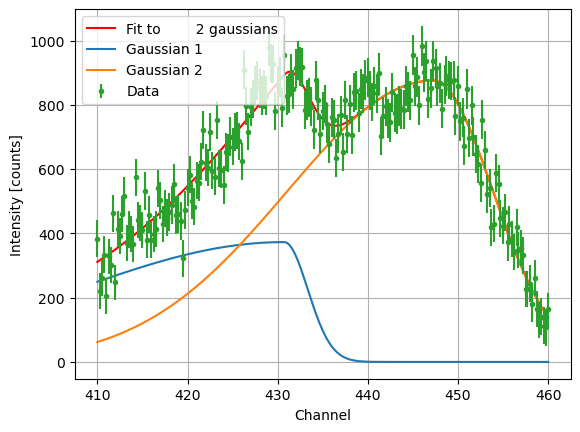

In [268]:
index = get_indices_in_range(step, 410, 460)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [900,430, 5,5,900,450,5,5]

par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 10

In [269]:
'''index = get_indices_in_range(step, 470, 557)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [800,490,5,1100,500, 5,1100,530,5, 800,550,5]

par, err_par = fit_peak(x,data,err_data,p0)

#nickel_parameters = np.append(nickel_parameters,par)
#err_nickel_parameters= np.append(err_nickel_parameters,err_par)'''

'index = get_indices_in_range(step, 470, 557)\nx = step[index]\ndata = nickel[index]\nerr_data = err_nickel[index]\n\np0 = [800,490,5,1100,500, 5,1100,530,5, 800,550,5]\n\npar, err_par = fit_peak(x,data,err_data,p0)\n\n#nickel_parameters = np.append(nickel_parameters,par)\n#err_nickel_parameters= np.append(err_nickel_parameters,err_par)'

### Gaussian 0 ####
Peak position 482.0 +/- 4.0 channel
Peak height 600.0 +/- 500.0 counts
Peak width left 7.0 +/- 1.0 channel
Peak width right 7.0 +/- 4.0 channel
### Gaussian 1 ####
Peak position 500.0 +/- 1.0 channel
Peak height 1000.0 +/- 200.0 counts
Peak width left 9.0 +/- 7.0 channel
Peak width right 6.3 +/- 0.8 channel
### Gaussian 2 ####
Peak position 529.7 +/- 0.6 channel
Peak height 1080.0 +/- 10.0 counts
Peak width left 12.5 +/- 0.8 channel
Peak width right 10.0 +/- 2.0 channel
### Gaussian 3 ####
Peak position 552.1 +/- 0.5 channel
Peak height 480.0 +/- 80.0 counts
Peak width left 6.0 +/- 2.0 channel
Peak width right 3.2 +/- 0.5 channel
Chi squared / dof 1.0778557144465761


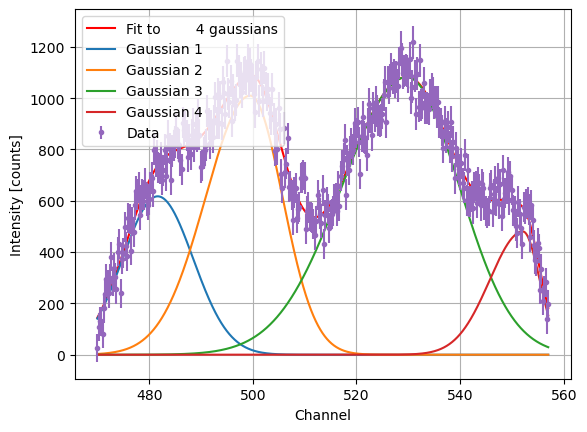

In [270]:
index = get_indices_in_range(step, 470, 557)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [800,490,3,2,1100,500, 3,2,1100,530,3,2, 800,550,3,2]

par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 11

In [271]:
'''index = get_indices_in_range(step, 575, 639)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]


p0 = [900,600, 10,]

par, err_par = fit_peak(x,data,err_data,p0)

#nickel_parameters = np.append(nickel_parameters,par)
#err_nickel_parameters= np.append(err_nickel_parameters,err_par)'''

'index = get_indices_in_range(step, 575, 639)\nx = step[index]\ndata = nickel[index]\nerr_data = err_nickel[index]\n\n\np0 = [900,600, 10,]\n\npar, err_par = fit_peak(x,data,err_data,p0)\n\n#nickel_parameters = np.append(nickel_parameters,par)\n#err_nickel_parameters= np.append(err_nickel_parameters,err_par)'

### Gaussian 0 ####
Peak position 608.0 +/- 1.0 channel
Peak height 400.0 +/- 8.0 counts
Peak width left 17.0 +/- 1.0 channel
Peak width right 19.0 +/- 1.0 channel
Chi squared / dof 1.394832714823267


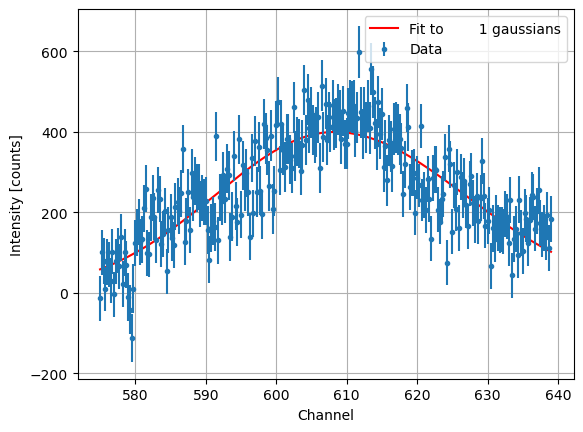

In [272]:
index = get_indices_in_range(step, 575, 639)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]


p0 = [900,600, 5,5]

par, err_par = fit_peak_asymmetric(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Plot the fit for the whole pattern

[2.05273578e+04 1.17143438e+02 1.88912775e+00 1.24742881e+00
 9.79027971e+03 1.33504478e+02 2.32165307e+00 1.39908807e+00
 6.33841456e+03 1.84929190e+02 3.62340428e+00 1.74389260e+00
 7.45889517e+03 2.15858656e+02 4.59670165e+00 2.28666460e+00
 2.27518450e+03 2.25359147e+02 3.70841730e+00 2.14273933e+00
 7.82930747e+02 2.58194854e+02 4.78817790e+00 4.78817790e+00
 3.94227673e+03 2.84965153e+02 6.52599633e+00 2.73493968e+00
 2.35962667e+03 2.93434027e+02 4.87964500e+00 1.85184738e+00
 1.59218502e+03 3.21388879e+02 9.21122609e+00 2.45687593e+00
 1.76655739e+03 3.43214546e+02 1.12266605e+01 2.59009570e+00
 2.47871145e+03 3.95173703e+02 1.20762117e+01 6.98884457e+00
 3.72901607e+02 4.30725112e+02 2.31153124e+01 2.60637239e+00
 8.75547644e+02 4.47218944e+02 1.61651968e+01 6.65747352e+00
 6.17491382e+02 4.81643328e+02 6.77210350e+00 6.84705419e+00
 1.00991481e+03 4.99502136e+02 8.62898105e+00 6.25828422e+00
 1.08203994e+03 5.29708886e+02 1.25238672e+01 1.01593948e+01
 4.80247567e+02 5.521246

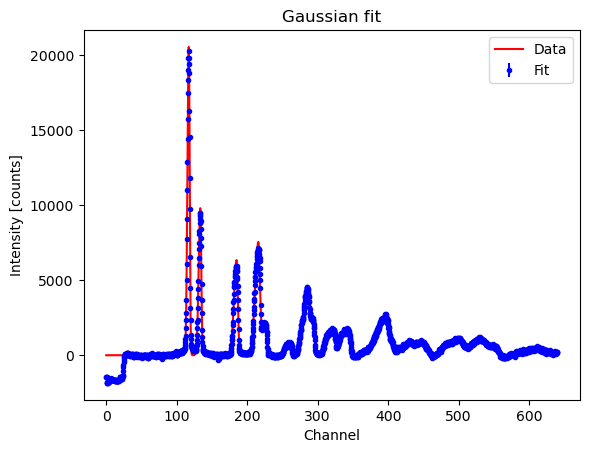

In [273]:
#%matplotlib ipympl
x_plot = np.linspace(min(step), max(step),10000)
print(nickel_parameters)

plt.errorbar(step,nickel,yerr = err_nickel,fmt='.',color='blue')
plt.plot(x_plot, asymmetric_gaussian_sum(x_plot, *nickel_parameters),color='red')
plt.title('Gaussian fit')
plt.legend(['Data','Fit'])
plt.xlabel('Channel')
plt.ylabel('Intensity [counts]')
plt.show()

In [274]:
nickel_peaks = []
err_nickel_peaks = []
width_nickel_peaks = []
err_width_nickel_peaks = []
width_nickel_peaks_l = []
err_width_nickel_peaks_l = []
width_nickel_peaks_r = []
err_width_nickel_peaks_r = []

for i in range (len(nickel_parameters)//4):
    nickel_peaks.append(nickel_parameters[4*i+1])
    err_nickel_peaks.append(err_nickel_parameters[4*i+1])
    width_nickel_peaks_l.append(nickel_parameters[4*i+2])
    err_width_nickel_peaks_l.append(err_nickel_parameters[4*i+2])
    width_nickel_peaks_r.append(nickel_parameters[4*i+3])
    err_width_nickel_peaks_r.append(err_nickel_parameters[4*i+3])
    width_nickel_peaks.append((width_nickel_peaks_r[i]+width_nickel_peaks_l[i])/2)
    err_width_nickel_peaks.append(np.sqrt(err_width_nickel_peaks_r[i]**2+err_width_nickel_peaks_l[i]**2)/2)
print(nickel_peaks,err_nickel_peaks)
print(width_nickel_peaks,err_width_nickel_peaks)


[117.143438446756, 133.50447802476558, 184.9291899122653, 215.85865630845217, 225.35914718443638, 258.1948537798735, 284.9651525700837, 293.4340272362793, 321.38887860222457, 343.21454637931157, 395.1737032761656, 430.72511249627036, 447.21894447068024, 481.64332803426754, 499.50213554843185, 529.7088864723703, 552.1246646433026, 608.2452407365366] [0.03439226030073263, 0.049740582669130895, 0.1254188271804572, 0.129555424852113, 0.3581149054199125, 0.2003135430246067, 0.17959328651191653, 0.13985165731567242, 0.26838013328962546, 0.24649269825404346, 0.19297246459976977, 0.7876400747956583, 0.4130834103113654, 4.291944867936319, 1.4905952927670767, 0.5501829102449801, 0.4873411316802535, 1.1942001557348063]
[1.5682782822568249, 1.8603705716690435, 2.6836484385365056, 3.441683122874662, 2.92557831206033, 4.7881779038435575, 4.630468004935402, 3.3657461896258725, 5.834051013992551, 6.908378079288268, 9.532528109679568, 12.860842413175591, 11.411335152684543, 6.809578842916547, 7.4436326

Index peaks and average fit values between repetitions

In [275]:
#Fit peaks position to Bragg law

# lattice parameters
a = 3.524 # Angstrom   at 293 K from "High-temperature thermal expansion of six metallic elements measured by dilatation method and X-ray diffraction Sample: at T = 1433 K"

# allowed reflections
h = np.array([1,2,2,3,2,4,3,4,4,5,4,4,6,6,4,6,6,7,8,7])
k = np.array([1,0,2,1,2,0,3,2,2,1,4,4,2,2,4,4,4,3,0,5])
l = np.array([1,0,0,1,2,0,1,0,2,1,0,2,0,2,4,0,2,1,0,1])

d_inv = np.sqrt((h**2+k**2+l**2)/a**2)
x = np.arcsin(0.729*d_inv/2)



Fit to bragg law, both with three free parameters ($\lambda, \theta_0$ and $\Delta \theta$) and two free parameters, fix $\Delta \theta = 0.2^{\circ}$

In [276]:
#fit to bragg law

'''def bragg(d_inv, lmbd,theta0, d_theta):
    pippo = np.arcsin(lmbd*d_inv/2)
    return (pippo-theta0)/d_theta

nickel_peaks_new = np.array(remove_indexes(nickel_peaks,[1,3,5,7,10,14,17]))
err_nickel_peaks_new = np.array(remove_indexes(err_nickel_peaks,[1,3,5,7,10,14,17]))

p0 = [0.72,-3*np.pi/360,0.2*np.pi/360]
bounds = ([0.1,-np.inf,0.1*np.pi/360],[0.8,np.inf,0.9*np.pi/360])

popt, pcov = curve_fit(bragg, d_inv, nickel_peaks_new[:], sigma = err_nickel_peaks_new[:],bounds = bounds, maxfev=800000) 


chi_sq = sum((bragg(d_inv,*popt)-nickel_peaks_new[:])**2/err_nickel_peaks_new[:]**2)/(np.size(nickel_peaks_new[:])-3)

print(' #### Fit to Bragg law ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))

print('lambda',popt[0], '+/-', np.sqrt(pcov[0][0]),'Angstrom')
print('theta0',par[1][0]*360/np.pi, '+/-', par[1][1]*360/np.pi,'deg')
print('delta_theta',par[2][0]*360/np.pi, '+/-', par[2][1]*360/np.pi,'deg')

print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(d_inv), max(d_inv),10000)
plt.plot(x_plot, bragg(x_plot, *popt),color='red')
plt.errorbar(d_inv,nickel_peaks_new[:], yerr=err_nickel_peaks_new[:],fmt='.',color='blue')
plt.title('Bragg fit')
plt.legend(['Fit', 'Data'])
plt.ylabel('Channel')
plt.xlabel('Inverse d spacing [1/Angstrom]')
plt.show()'''


"def bragg(d_inv, lmbd,theta0, d_theta):\n    pippo = np.arcsin(lmbd*d_inv/2)\n    return (pippo-theta0)/d_theta\n\nnickel_peaks_new = np.array(remove_indexes(nickel_peaks,[1,3,5,7,10,14,17]))\nerr_nickel_peaks_new = np.array(remove_indexes(err_nickel_peaks,[1,3,5,7,10,14,17]))\n\np0 = [0.72,-3*np.pi/360,0.2*np.pi/360]\nbounds = ([0.1,-np.inf,0.1*np.pi/360],[0.8,np.inf,0.9*np.pi/360])\n\npopt, pcov = curve_fit(bragg, d_inv, nickel_peaks_new[:], sigma = err_nickel_peaks_new[:],bounds = bounds, maxfev=800000) \n\n\nchi_sq = sum((bragg(d_inv,*popt)-nickel_peaks_new[:])**2/err_nickel_peaks_new[:]**2)/(np.size(nickel_peaks_new[:])-3)\n\nprint(' #### Fit to Bragg law ####')\npar = my_round(popt,np.sqrt(np.diag(pcov)))\n\nprint('lambda',popt[0], '+/-', np.sqrt(pcov[0][0]),'Angstrom')\nprint('theta0',par[1][0]*360/np.pi, '+/-', par[1][1]*360/np.pi,'deg')\nprint('delta_theta',par[2][0]*360/np.pi, '+/-', par[2][1]*360/np.pi,'deg')\n\nprint('Chi squared/ dof',chi_sq)\n\nx_plot = np.linspace(min(d

 #### Fit to Bragg law ####
lambda 0.74 +/- 0.002 Angstrom
theta0 -2.4637185190625397 +/- 0.06875493541569878 deg
Chi squared/ dof 27.846121711559743


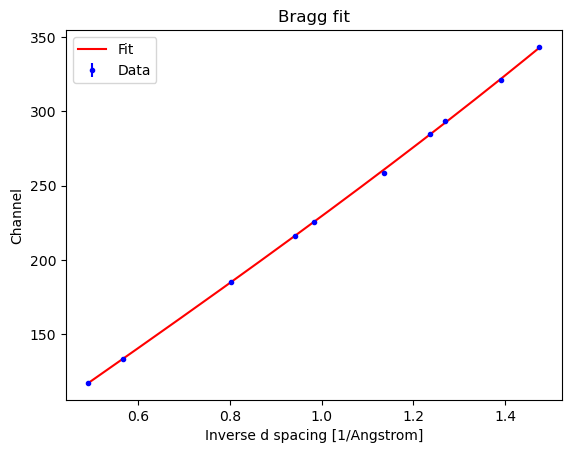

In [277]:
#Fix delta theta = 0.2 deg
#%matplotlib ipympl
nickel_peaks_new = np.array(nickel_peaks[0:10])
err_nickel_peaks_new = np.array(err_nickel_peaks[0:10])

def bragg_fix(d_inv,lmbd,theta0):
    pippo = np.arcsin(lmbd*d_inv/2)
    return (pippo-theta0)/(0.2*np.pi/360)

p0 = [0.72,-3*np.pi/360]
bounds = ([0.1,-np.inf],[1,np.inf])
popt, pcov = curve_fit(bragg_fix, d_inv[0:10], nickel_peaks_new[0:10], sigma = err_nickel_peaks_new[0:10],bounds = bounds, maxfev=800000) 


chi_sq = sum((bragg_fix(d_inv[0:10],*popt)-nickel_peaks_new[:])**2/err_nickel_peaks_new[:]**2)/(np.size(nickel_peaks_new[:])-2)

lamda = popt[0]
err_lamda = np.sqrt(pcov[0][0])

theta0 = popt[1]*360/np.pi
err_theta0 = np.sqrt(pcov[1][1])*360/np.pi

print(' #### Fit to Bragg law ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))

print('lambda',par[0][0], '+/-', par[0][1],'Angstrom')
print('theta0',par[1][0]*360/np.pi, '+/-', par[1][1]*360/np.pi,'deg')

print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(d_inv), max(d_inv[0:10]),10000)
plt.plot(x_plot, bragg_fix(x_plot, *popt),color='red')
plt.errorbar(d_inv[0:10],nickel_peaks_new[:], yerr=err_nickel_peaks_new[:],fmt='.',color='blue')
plt.title('Bragg fit')
plt.legend(['Fit', 'Data'])
plt.ylabel('Channel')
plt.xlabel('Inverse d spacing [1/Angstrom]')
plt.show()



 #### Fit to Bragg law ####
Slope 583.0 +/- 2.0 channel
Intercept 12.2 +/- 0.5 channel
#####
dtheta 0.1967072464597512 +/- 0.003464348123360727 deg
theta0 -2.3923176878353676 +/- 0.0936149785288586 deg
Chi squared/ dof 27.846121711559743


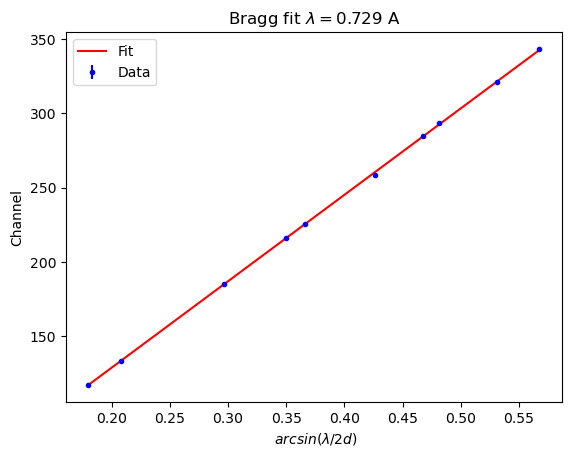

In [278]:
#linear fit to arcsin (fix lambda)


bounds = [[-np.inf,-np.inf],[np.inf,np.inf]]
popt, pcov = curve_fit(lin_fit, x[0:8], nickel_peaks_new[0:8], sigma =err_nickel_peaks_new[0:8],bounds = bounds, maxfev = 80000)

#chi_sq = sum((lin_fit(x[0:7],*popt)-nickel_peaks_new[0:7])**2/err_nickel_peaks_new[0:7]**2)/(np.size(nickel_peaks_new[0:7])-2)

print(' #### Fit to Bragg law ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))
print('Slope',par[0][0], '+/-', par[0][1],'channel')
print('Intercept',par[1][0], '+/-', par[1][1],'channel')
print('#####')

d_theta = 1/popt[0]*360/np.pi
err_d_theta = np.sqrt(pcov[0][0])/popt[0]

theta0 = -360/np.pi*popt[1]/popt[0]
err_theta0= abs(theta0)*np.sqrt(pcov[1][1]/popt[1]**2+pcov[0][0]/popt[0]**2)

print('dtheta',d_theta, '+/-', err_d_theta,'deg')
print('theta0',theta0, '+/-', err_theta0,'deg')
print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(x), max(x[0:10]),10000)
plt.plot(x_plot, lin_fit(x_plot, *popt),color='red')
plt.errorbar(x[0:10],nickel_peaks_new[0:10], yerr=err_nickel_peaks_new[0:10],fmt='.',color='blue')
plt.title(r'Bragg fit $\lambda = 0.729$ A')
plt.legend(['Fit', 'Data'])
plt.ylabel('Channel')
plt.xlabel(r' $arcsin(\lambda/2 d)$')
plt.show()


Build calibration curve: give channel in input obtain corresponding $2 \theta$ in output

In [279]:
def calibration_curve(x,dx):
    x = np.array(x)
    dx = np.array(dx)
    return theta0 + 0.2*x, np.sqrt(err_theta0**2 + (0.2*dx)**2)

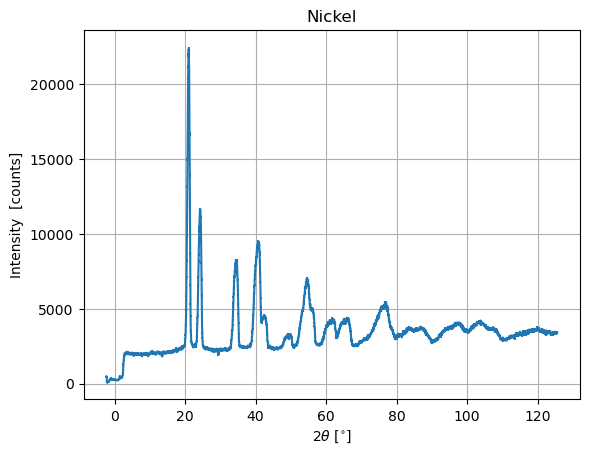

In [280]:
twotheta = calibration_curve(step,np.zeros(len(step)))[0]

#%matplotlib ipympl
plt.errorbar(twotheta,nickel_back, fmt = '-', yerr = err_nickel_back)
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel')
plt.grid()
plt.show()

Fit peak widths to Cagliolo function  
$$
FWHM(2 \theta) = \sqrt{W_0 + W_1 \tan(\theta)+ W_2 \tan(\theta)^2}
$$

In [281]:
def cagliolo_fit(x, w0,w1,w2):
    rad = x*np.pi/360
    return np.sqrt(w0+w1*np.tan(rad)+ w2*np.tan(rad)**2)

Find FWHM in $2 \theta$

In [282]:
width_nickel_peaks_new = np.array(width_nickel_peaks[0:10])
err_width_nickel_peaks_new = np.array(err_width_nickel_peaks[0:10])

half_inf = nickel_peaks_new - width_nickel_peaks_new*np.sqrt(2*np.log(2))
err_half_inf = np.sqrt(err_nickel_peaks_new**2+err_width_nickel_peaks_new**2*2*np.log(2))

half_sup = nickel_peaks_new + width_nickel_peaks_new*np.sqrt(2*np.log(2))
err_half_sup = np.sqrt(err_nickel_peaks_new**2+err_width_nickel_peaks_new**2*2*np.log(2))

inf_deg, err_inf_deg = calibration_curve(half_inf, err_half_inf)
sup_deg, err_sup_deg = calibration_curve(half_sup, err_half_sup)

fwhm = sup_deg - inf_deg
err_fwhm = np.sqrt(err_inf_deg**2+err_sup_deg**2)

print(fwhm, err_fwhm)


[0.73860263 0.87616758 1.26390183 1.62090888 1.37784209 2.25505946
 2.18078378 1.58514532 2.74762805 3.25359744] [0.13288612 0.13346058 0.13931782 0.14162154 0.21950499 0.15515851
 0.14376928 0.18090057 0.16719607 0.16994643]


 #### Fit to Cagliolo function ####
W0 1.1 +/- 0.8 deg^2
W1 -9.0 +/- 5.0 deg^2
W2 34.0 +/- 7.0 deg^2
Chi squared/ dof 0.5930083193180191


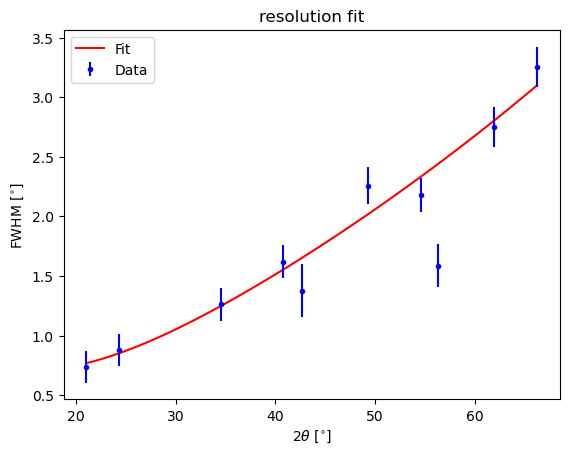

In [283]:

peaks = calibration_curve(nickel_peaks_new, err_nickel_peaks_new)[0]

fwhm_new = np.array(remove_indexes(fwhm, [4,5,7]))
err_fwhm_new = np.array(remove_indexes(err_fwhm, [4,5,7]))
peaks_new = np.array(remove_indexes(peaks, [4,5,7]))

popt, pcov = curve_fit(cagliolo_fit, peaks_new, fwhm_new, sigma= err_fwhm_new)

chi_sq = sum((cagliolo_fit(peaks_new,*popt)-fwhm_new)**2/err_fwhm_new**2)/(len(fwhm_new)-3)


print(' #### Fit to Cagliolo function ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))

print('W0',par[0][0], '+/-', par[0][1],'deg^2')
print('W1',par[1][0], '+/-', par[1][1],'deg^2')
print('W2',par[2][0], '+/-', par[2][1],'deg^2')

print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(peaks), max(peaks),10000)
plt.plot(x_plot, cagliolo_fit(x_plot, *popt),color='red')
plt.errorbar(peaks,fwhm, yerr=err_fwhm, fmt='.',color='blue')
plt.title('resolution fit')
plt.legend(['Fit', 'Data'])
plt.ylabel(r'FWHM [$^{\circ}$]')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.show()

Try to estimate TDS:  
$$
S_T(2 \theta) = 1- e^{-2 B \left(\sin \theta/\lambda\right)^2}
$$
with $2 B = 0.3559 \AA^2$


In [284]:
def tds(x, lamda,B):  # give twotheta in input in deg
    return 1- np.exp(-2*B*(np.sin(x*np.pi/360)/lamda)**2)

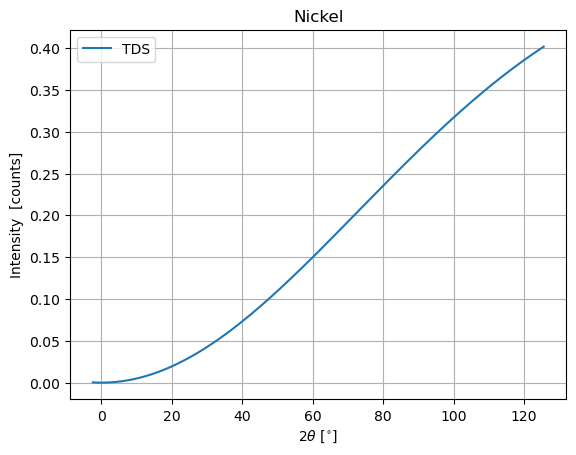

In [285]:
B = 0.3559/2 # Angstrom^2

thermal = tds(twotheta, lamda,B)

#plt.errorbar(twotheta,nickel_back, fmt = '-', yerr = err_nickel_back, label = 'Data')
plt.plot(twotheta, thermal, label = 'TDS')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel')
plt.legend()
plt.grid()
plt.show()

Fit the whole profile as
$$
I(2 \theta) = I_B(2 \theta) + I_T(2 \theta) + bkg
$$
with $I_B(2 \theta)$ the Bragg peaks intensity fitted before (with linear background subtraction), $I_T(2 \theta) = A S_T(2 \theta)$ and $bkg$ a constant background from incoherent scattering

In [286]:
nickel_peaks = np.array(nickel_peaks)
err_nickel_peaks = np.array(err_nickel_peaks)

width_nickel_peaks_l = np.array(width_nickel_peaks_l)
err_width_nickel_peaks_l = np.array(err_width_nickel_peaks_l)

half_inf = nickel_peaks - width_nickel_peaks_l/2
err_half_inf = np.sqrt(err_nickel_peaks**2+err_width_nickel_peaks_l**2/4)

half_sup = nickel_peaks + width_nickel_peaks_l/2
err_half_sup = np.sqrt(err_nickel_peaks**2+err_width_nickel_peaks_l**2/4)

inf_deg, err_inf_deg = calibration_curve(half_inf, err_half_inf)
sup_deg, err_sup_deg = calibration_curve(half_sup, err_half_sup)

width_deg_l = sup_deg - inf_deg
err_width_deg_l = np.sqrt(err_inf_deg**2+err_sup_deg**2)

width_nickel_peaks_r = np.array(width_nickel_peaks_r)
err_width_nickel_peaks_r = np.array(err_width_nickel_peaks_r)

half_inf = nickel_peaks - width_nickel_peaks_r/2
err_half_inf = np.sqrt(err_nickel_peaks**2+err_width_nickel_peaks_r**2/4)

half_sup = nickel_peaks + width_nickel_peaks_r/2
err_half_sup = np.sqrt(err_nickel_peaks**2+err_width_nickel_peaks_r**2/4)

inf_deg, err_inf_deg = calibration_curve(half_inf, err_half_inf)
sup_deg, err_sup_deg = calibration_curve(half_sup, err_half_sup)

width_deg_r = sup_deg - inf_deg
err_width_deg_r = np.sqrt(err_inf_deg**2+err_sup_deg**2)


parameters_theta = np.zeros(len(nickel_parameters))
err_parameters_theta = np.zeros(len(nickel_parameters))

for i in range(len(nickel_parameters)//4):
    parameters_theta[4*i] = nickel_parameters[4*i]
    parameters_theta[4*i+1] = calibration_curve(nickel_parameters[4*i+1], err_nickel_parameters[4*i+1])[0]
    parameters_theta[4*i+2] = width_deg_l[i]
    parameters_theta[4*i+3] = width_deg_r[i]

    err_parameters_theta[4*i] = err_nickel_parameters[4*i]
    err_parameters_theta[4*i+1] = calibration_curve(nickel_parameters[4*i+1], err_nickel_parameters[4*i+1])[1]
    err_parameters_theta[4*i+2] = err_width_deg_l[i]
    err_parameters_theta[4*i+3] = err_width_deg_r[i]

print(parameters_theta)

[2.05273578e+04 2.10363700e+01 3.77825551e-01 2.49485762e-01
 9.79027971e+03 2.43085779e+01 4.64330614e-01 2.79817614e-01
 6.33841456e+03 3.45935203e+01 7.24680856e-01 3.48778519e-01
 7.45889517e+03 4.07794136e+01 9.19340330e-01 4.57332919e-01
 2.27518450e+03 4.26795117e+01 7.41683460e-01 4.28547865e-01
 7.82930747e+02 4.92466531e+01 9.57635581e-01 9.57635581e-01
 3.94227673e+03 5.46007128e+01 1.30519927e+00 5.46987936e-01
 2.35962667e+03 5.62944878e+01 9.75929000e-01 3.70369476e-01
 1.59218502e+03 6.18854580e+01 1.84224522e+00 4.91375187e-01
 1.76655739e+03 6.62505916e+01 2.24533209e+00 5.18019140e-01
 2.47871145e+03 7.66424230e+01 2.41524233e+00 1.39776891e+00
 3.72901607e+02 8.37527048e+01 4.62306249e+00 5.21274479e-01
 8.75547644e+02 8.70514712e+01 3.23303936e+00 1.33149470e+00
 6.17491382e+02 9.39363479e+01 1.35442070e+00 1.36941084e+00
 1.00991481e+03 9.75081094e+01 1.72579621e+00 1.25165684e+00
 1.08203994e+03 1.03549460e+02 2.50477343e+00 2.03187897e+00
 4.80247567e+02 1.080326

In [287]:
def fit_full_profile(x,a,b):
    global B
    global lamda
    global parameters_theta
    return asymmetric_gaussian_sum(x,*parameters_theta)+a*(1- np.exp(-2*B*(np.sin(x*np.pi/360)/lamda)**2)) + b

 #### Fit to full profile ####
A 2680.0 +/- 20.0 counts
bkg 2099.0 +/- 4.0 counts
Chi squared/ dof 5.791369677371233


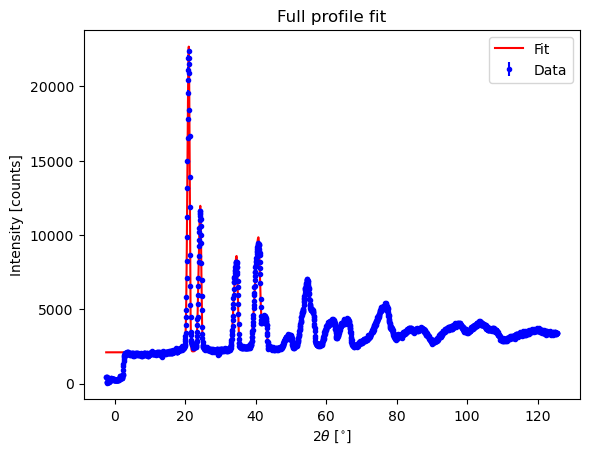

In [288]:
#%matplotlib ipympl

index = get_indices_in_range(twotheta,3,125) 
p0 = [3100,2000]
popt, pcov = curve_fit(fit_full_profile, twotheta[index], nickel_back[index], sigma= err_nickel_back[index], p0=p0)

chi_sq = sum((fit_full_profile(twotheta[index],*popt)-nickel_back[index])**2/err_nickel_back[index]**2)/(len(nickel_back[index])-2)


print(' #### Fit to full profile ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))

print('A',par[0][0], '+/-', par[0][1],'counts')
print('bkg',par[1][0], '+/-', par[1][1],'counts')

print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(twotheta), max(twotheta),10000)
plt.plot(x_plot, fit_full_profile(x_plot, *popt),color='red')
plt.errorbar(twotheta,nickel_back, yerr=err_nickel_back, fmt='.',color='blue')
plt.title('Full profile fit')
plt.legend(['Fit', 'Data'])
plt.ylabel(r'Intensity [counts]')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.show()